In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from mlrose_hiive import QueensGenerator, MaxKColorGenerator, TSPGenerator, ContinuousPeaksGenerator, FlipFlopGenerator, KnapsackGenerator
from mlrose_hiive import RHCRunner, SARunner, GARunner, MIMICRunner, NNGSRunner, SKMLPRunner

# Plot customization
plt.rcParams['axes.grid'] = True
plt.style.use('seaborn-colorblind')

# Read data and preprocessing

In [3]:
data = pd.read_csv('datasets_311_673_survey.csv')

print("Dataset Shape: ", data.shape)
data.head()

Dataset Shape:  (1259, 27)


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [ ]:
# Timestamps are all unique values
data = data.drop(['Timestamp'], axis= 1)

# Comments are optional free text field.
# There are only 164 comments and may not all related to the dataset
data = data.drop(['comments'], axis= 1)

# There are a lot of missing values in state. 
# This field can be ignore if not take the locations into account.
data = data.drop(['state'], axis= 1)

# Cleaning NaN values

default_int = 0
default_string = 'NaN'
default_float = 0.0

data['Age'].fillna(default_int)

for feature in ['Gender', 'Country', 'family_history', 'treatment',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']:
    data[feature] = data[feature].fillna(default_string)

print("Len(): ", len(data['Gender'].str.lower().unique()))
data['Gender'].str.lower().unique()

male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in data.iterrows():
    if str.lower(col.Gender) in male_str:
        data['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)
    if str.lower(col.Gender) in female_str:
        data['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)
    if str.lower(col.Gender) in trans_str:
        data['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

# Remove outlier that's not useful
stk_list = ['A little about you', 'p']
data = data[~data['Gender'].isin(stk_list)]

print(data['Gender'].unique())

# Remove outlier age

data.drop(data[data['Age'] < 0].index, inplace = True) 
data.drop(data[data['Age'] > 100].index, inplace = True) 

# Add column age_range
data['age_range'] = pd.cut(data['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)

print(data['self_employed'].value_counts())
data['self_employed'].fillna('No',inplace=True)

print(data['work_interfere'].value_counts())
data['work_interfere'].fillna('Sometimes',inplace=True)


In [6]:
# Drop 'Country' column
data = data.drop(['Country'], axis= 1)

data.isnull().sum()

Age                          0
Gender                       0
self_employed                0
family_history               0
treatment                    0
work_interfere               0
no_employees                 0
remote_work                  0
tech_company                 0
benefits                     0
care_options                 0
wellness_program             0
seek_help                    0
anonymity                    0
leave                        0
mental_health_consequence    0
phys_health_consequence      0
coworkers                    0
supervisor                   0
mental_health_interview      0
phys_health_interview        0
mental_vs_physical           0
obs_consequence              0
age_range                    0
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

labelDict = {}
for feature in data:
    le = preprocessing.LabelEncoder()
    le.fit(data[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    data[feature] = le.transform(data[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

label_Age [5, 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]
label_Gender ['female', 'male', 'trans']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ['Never', 'Often', 'Rarely', 'Sometimes']
label_no_employees ['1-5', '100-500', '26-100', '500-1000', '6-25', 'More than 1000']
label_remote_work ['No', 'Yes']
label_tech_company ['No', 'Yes']
label_benefits ["Don't know", 'No', 'Yes']
label_care_options ['No', 'Not sure', 'Yes']
label_wellness_program ["Don't know", 'No', 'Yes']
label_seek_help ["Don't know", 'No', 'Yes']
label_anonymity ["Don't know", 'No', 'Yes']
label_leave ["Don't know", 'Somewhat difficult', 'Somewhat easy', 'Very difficult', 'Very easy']
label_mental_health_consequence ['Maybe', 'No', 'Yes']
label_phys_health_consequence ['Maybe', 'No', 'Yes']
label_coworkers 

In [8]:
scaler = MinMaxScaler()
data['Age'] = scaler.fit_transform(data[['Age']])
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.456522,0,0,0,1,1,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,0.608696,1,0,0,0,2,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,0.347826,1,0,0,0,2,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,0.326087,1,0,1,1,1,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,0.326087,1,0,0,0,0,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


In [9]:
data.columns

Index(['Age', 'Gender', 'self_employed', 'family_history', 'treatment',
       'work_interfere', 'no_employees', 'remote_work', 'tech_company',
       'benefits', 'care_options', 'wellness_program', 'seek_help',
       'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'age_range'],
      dtype='object')

In [12]:
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, cross_val_score
from external_fn import plot_learning_curve, plot_validation_curve, plot_roc_auc_curve

x = data[['Age', 'Gender', 'self_employed', 'family_history',
       'work_interfere', 'no_employees', 'remote_work', 'tech_company',
       'benefits', 'care_options', 'wellness_program', 'seek_help',
       'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'age_range' ]]
y = data['treatment']

# Plot customization
plt.rcParams['axes.grid'] = True
plt.style.use('seaborn-colorblind')

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42)

In [14]:
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [17]:
# ensure defaults are in grid search
default_grid_search_parameters = {
    'max_iters': [5000],
    'learning_rate_init': [0.1, 0.2, 0.4, 0.8],
    'hidden_layer_sizes': [[5, 5, 5]],
    'activation': [mlrose_hiive.neural.activation.relu],
}

default_parameters = {
    'seed': 42,
    'iteration_list': 2 ** np.arange(13),
    'max_attempts': 5000,
    'override_ctrl_c_handler': False, # required for running in notebook
    'n_jobs':5,
    'cv':10,
}

In [44]:
rhc_grid_search_parameters = {
    'max_iters': [5000],                          # nn params
    'learning_rate_init': [0.001],
    'learning_rate': [0.001],                       # nn params
    'activation': [mlrose_hiive.relu],            # nn params
    'restarts': [25],                             # rhc params
}

rhc_nnr = NNGSRunner(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    experiment_name='nn_test_rhc',
    algorithm=mlrose_hiive.algorithms.rhc.random_hill_climb,
    grid_search_parameters=rhc_grid_search_parameters,
    iteration_list=[1, 10, 50, 100, 250, 500, 1000],
    hidden_layer_sizes=[[5, 5, 5]],
    bias=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=500,
    n_jobs=5,
    seed=42,
    output_directory='Users/fony/machine-learning/randomized_optimization/results_nn'
)


rhc_run_stats_df, rhc_curves_df, rhc_cv_results_df, rhc_grid_search_cv = rhc_nnr.run()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [33]:
rhc_grid_search_cv

GridSearchCV(cv=5,
             estimator=NNClassifier(algorithm=<function random_hill_climb at 0x107835430>,
                                    clip_max=5, early_stopping=True,
                                    learning_rate=None, max_attempts=500,
                                    restarts=None,
                                    runner=<mlrose_hiive.runners.nngs_runner.NNGSRunner object at 0x2804ad490>,
                                    seed=42),
             n_jobs=5,
             param_grid={'activation': [<function relu at 0x107835b80>],
                         'hidden_layer_sizes': [[5, 5, 5]],
                         'learning_rate': [0.001],
                         'learning_rate_init': [0.001], 'max_iters': [1000],
                         'restarts': [25]},
             return_train_score=True,
             scoring=make_scorer(_grid_search_score_intercept), verbose=True)

In [34]:
rhc_cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_learning_rate,param_learning_rate_init,param_max_iters,param_restarts,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,192.05631,0.270738,0.002981,0.001777,relu,"[5, 5, 5]",0.001,0.001,1000,25,...,0.505209,0.012596,1,0.501548,0.511069,0.508514,0.503172,0.50847,0.506555,0.003589


In [35]:
rhc_curves_df

,Iteration,Time,Fitness,FEvals,max_iters,learning_rate,restarts,init_state,algorithm,activation,bias,early_stopping,clip_max,hidden_layer_sizes,learning_rate_init,max_attempts,current_restart
0,0,0.009725,0.857590,1.0,1000,0.001,25,"[-0.250919762305275, 0.9014286128198323, 0.463...",rhc,relu,True,True,5,"[5, 5, 5]",0.001,500,0
1,1,0.027330,0.857590,2.0,1000,0.001,25,"[-0.250919762305275, 0.9014286128198323, 0.463...",rhc,relu,True,True,5,"[5, 5, 5]",0.001,500,0
2,2,0.033662,0.857590,3.0,1000,0.001,25,"[-0.250919762305275, 0.9014286128198323, 0.463...",rhc,relu,True,True,5,"[5, 5, 5]",0.001,500,0
3,3,0.034283,0.857590,4.0,1000,0.001,25,"[-0.250919762305275, 0.9014286128198323, 0.463...",rhc,relu,True,True,5,"[5, 5, 5]",0.001,500,0
4,4,0.035295,0.857544,6.0,1000,0.001,25,"[-0.250919762305275, 0.9014286128198323, 0.463...",rhc,relu,True,True,5,"[5, 5, 5]",0.001,500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25996,996,0.813973,0.844717,37577.0,1000,0.001,25,"[-0.250919762305275, 0.9014286128198323, 0.463...",rhc,relu,True,True,5,"[5, 5, 5]",0.001,500,25
25997,997,0.814529,0.844717,37579.0,1000,0.001,25,"[-0.250919762305275, 0.9014286128198323, 0.463...",rhc,relu,True,True,5,"[5, 5, 5]",0.001,500,25
25998,998,0.815105,0.844717,37580.0,1000,0.001,25,"[-0.250919762305275, 0.9014286128198323, 0.463...",rhc,relu,True,True,5,"[5, 5, 5]",0.001,500,25
25999,999,0.815726,0.844713,37582.0,1000,0.001,25,"[-0.250919762305275, 0.9014286128198323, 0.463...",rhc,relu,True,True,5,"[5, 5, 5]",0.001,500,25


In [46]:
from mlrose_hiive.algorithms.decay import ArithDecay

sa_grid_search_parameters = {
    'max_iters': [5000],                          # nn params
    'learning_rate_init': [0.001],
    'learning_rate': [0.001],                       # nn params
    'activation': [mlrose_hiive.relu],            # nn params
    'schedule': [ArithDecay(1), ArithDecay(100), ArithDecay(1000)]
}

sa_nnr = NNGSRunner(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    experiment_name='nn_test_sa',
    algorithm=mlrose_hiive.algorithms.sa.simulated_annealing,
    grid_search_parameters=sa_grid_search_parameters,
    iteration_list=[1, 10, 50, 100, 250, 500, 1000],
    hidden_layer_sizes=[[5, 5, 5]],
    bias=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=500,
    n_jobs=5,
    seed=42,
    output_directory='Users/fony/machine-learning/randomized_optimization/results_nn'
)


sa_run_stats_df, sa_curves_df, sa_cv_results_df, sa_grid_search_cv = sa_nnr.run()

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [45]:
ga_grid_search_parameters = {
    'max_iters': [5000],                          # nn params
    'learning_rate_init': [0.001],
    'learning_rate': [0.001],                       # nn params
    'activation': [mlrose_hiive.relu],            # nn params
    'pop_size': [150],
    'mutation_prob': [0.4]
}


ga_nnr = NNGSRunner(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    experiment_name='nn_test_ga',
    algorithm=mlrose_hiive.algorithms.ga.genetic_alg,
    grid_search_parameters=ga_grid_search_parameters,
    iteration_list=[1, 10, 50, 100, 250, 500, 1000],
    hidden_layer_sizes=[[5, 5, 5]],
    bias=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=500,
    n_jobs=5,
    seed=42,
    output_directory='Users/fony/machine-learning/randomized_optimization/results_nn'
)


ga_run_stats_df, ga_curves_df, ga_cv_results_df, ga_grid_search_cv = ga_nnr.run()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [131]:
from mlrose_hiive.neural import NeuralNetwork
from sklearn.metrics import accuracy_score
import time

nn_model_rhc = NeuralNetwork(hidden_nodes=[5, 5, 5], activation='relu',
                                    algorithm='random_hill_climb', max_iters=1000,
                                    bias=True, is_classifier=True, learning_rate=0.001,
                                    early_stopping=True, clip_max=5, max_attempts=500,
                                    random_state=42, curve=True, restarts=50)
nn_model_sa = NeuralNetwork(hidden_nodes=[5, 5, 5], activation='relu',
                                   algorithm='simulated_annealing', max_iters=5000,
                                   bias=True, is_classifier=True, learning_rate=0.001,
                                   early_stopping=True, clip_max=5, max_attempts=500,
                                   random_state=42, curve=True, schedule=ArithDecay(1))
nn_model_ga = NeuralNetwork(hidden_nodes=[5, 5, 5], activation='relu',
                                   algorithm='genetic_alg', max_iters=5000,
                                   bias=True, is_classifier=True, learning_rate=0.001,
                                   early_stopping=True, clip_max=5, max_attempts=500,
                                   random_state=42, curve=True, pop_size=200, mutation_prob=0.1)

neural_nets = [nn_model_rhc, nn_model_sa, nn_model_ga]

for nn in neural_nets:
    t = time.time()
    nn.fit(x_train, y_train)

    y_train_pred = nn.predict(x_train)
    y_train_accuracy = accuracy_score(y_train, y_train_pred)
    print("Train accuracy for {}: {}".format(nn, y_train_accuracy))

    y_test_pred = nn.predict(x_test)
    y_test_accuracy = accuracy_score(y_test, y_test_pred)
    print("Test accuracy for {}: {}".format(nn, y_test_accuracy))
    print("Time needed: {}".format(time.time()-t))

Train accuracy for NeuralNetwork(clip_max=5, curve=True, early_stopping=True,
              hidden_nodes=[5, 5, 5], learning_rate=0.001, max_attempts=500,
              max_iters=1000, random_state=42, restarts=50): 0.5089820359281437
Test accuracy for NeuralNetwork(clip_max=5, curve=True, early_stopping=True,
              hidden_nodes=[5, 5, 5], learning_rate=0.001, max_attempts=500,
              max_iters=1000, random_state=42, restarts=50): 0.450199203187251
Time needed: 30.410663843154907
Train accuracy for NeuralNetwork(algorithm='simulated_annealing', clip_max=5, curve=True,
              early_stopping=True, hidden_nodes=[5, 5, 5], learning_rate=0.001,
              max_attempts=500, max_iters=5000, random_state=42,
              schedule=ArithDecay(init_temp=1, decay=0.0001, min_temp=0.001)): 0.4940119760479042
Test accuracy for NeuralNetwork(algorithm='simulated_annealing', clip_max=5, curve=True,
              early_stopping=True, hidden_nodes=[5, 5, 5], learning_rate=0.001

In [125]:
neural_nets[0].fitness_curve

array([[1.04727345e+00, 1.45375000e+05],
       [1.04727345e+00, 1.45376000e+05],
       [1.04727345e+00, 1.45377000e+05],
       ...,
       [1.01753327e+00, 1.46834000e+05],
       [1.01748821e+00, 1.46836000e+05],
       [1.01748821e+00, 1.46837000e+05]])

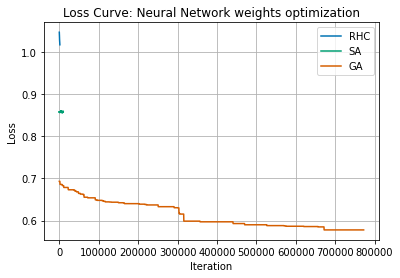

In [126]:
import matplotlib.pyplot as plt

plt.plot(neural_nets[0].fitness_curve.T[1] - neural_nets[0].fitness_curve.T[1][0], neural_nets[0].fitness_curve.T[0], label="RHC")
plt.plot(neural_nets[1].fitness_curve.T[1] - neural_nets[1].fitness_curve.T[1][0], neural_nets[1].fitness_curve.T[0], label="SA")
plt.plot(neural_nets[2].fitness_curve.T[1] - neural_nets[2].fitness_curve.T[1][0], neural_nets[2].fitness_curve.T[0], label="GA")
plt.xlabel("Iteration")
plt.ylabel("Loss")
# plt.xlim(0,3000)
plt.title(f"Loss Curve: Neural Network weights optimization")
plt.legend(loc="upper right")
plt.show()

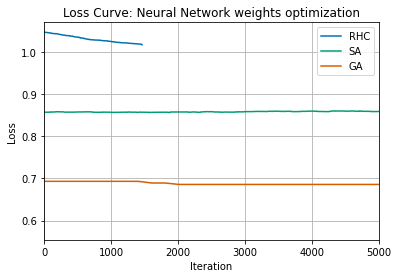

In [127]:
plt.plot(neural_nets[0].fitness_curve.T[1] - neural_nets[0].fitness_curve.T[1][0], neural_nets[0].fitness_curve.T[0], label="RHC")
plt.plot(neural_nets[1].fitness_curve.T[1] - neural_nets[1].fitness_curve.T[1][0], neural_nets[1].fitness_curve.T[0], label="SA")
plt.plot(neural_nets[2].fitness_curve.T[1] - neural_nets[2].fitness_curve.T[1][0], neural_nets[2].fitness_curve.T[0], label="GA")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.xlim(0,5000)
plt.title(f"Loss Curve: Neural Network weights optimization")
plt.legend(loc="upper right")
plt.show()

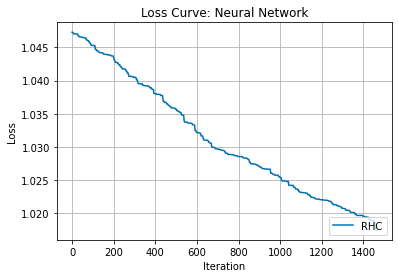

In [128]:
plt.plot(neural_nets[0].fitness_curve.T[1] - neural_nets[0].fitness_curve.T[1][0], neural_nets[0].fitness_curve.T[0], label="RHC")
# plt.plot(neural_nets[1].fitness_curve.T[1] - neural_nets[1].fitness_curve.T[1][0], neural_nets[1].fitness_curve.T[0], label="SA")
# plt.plot(neural_nets[2].fitness_curve.T[1] - neural_nets[2].fitness_curve.T[1][0], neural_nets[2].fitness_curve.T[0], label="GA")
plt.xlabel("Iteration")
plt.ylabel("Loss")
# plt.xlim(0,1800)
plt.title(f"Loss Curve: Neural Network")
plt.legend(loc="lower right")
plt.show()

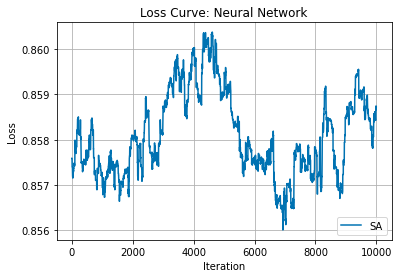

In [129]:
import matplotlib.pyplot as plt

# plt.plot(neural_nets[0].fitness_curve.T[1] - neural_nets[0].fitness_curve.T[1][0], neural_nets[0].fitness_curve.T[0], label="RHC")
plt.plot(neural_nets[1].fitness_curve.T[1] - neural_nets[1].fitness_curve.T[1][0], neural_nets[1].fitness_curve.T[0], label="SA")
# plt.plot(neural_nets[2].fitness_curve.T[1] - neural_nets[2].fitness_curve.T[1][0], neural_nets[2].fitness_curve.T[0], label="GA")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(f"Loss Curve: Neural Network")
plt.legend(loc="lower right")
plt.show()

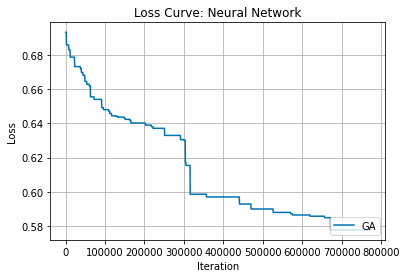

In [130]:
import matplotlib.pyplot as plt

# plt.plot(neural_nets[0].fitness_curve.T[1] - neural_nets[0].fitness_curve.T[1][0], neural_nets[0].fitness_curve.T[0], label="RHC")
# plt.plot(neural_nets[1].fitness_curve.T[1] - neural_nets[1].fitness_curve.T[1][0], neural_nets[1].fitness_curve.T[0], label="SA")
plt.plot(neural_nets[2].fitness_curve.T[1] - neural_nets[2].fitness_curve.T[1][0], neural_nets[2].fitness_curve.T[0], label="GA")
plt.xlabel("Iteration")
plt.ylabel("Loss")
# plt.xlim(0,15000)
plt.title(f"Loss Curve: Neural Network")
plt.legend(loc="lower right")
plt.show()